# Выполнение в google colab


In [1]:
# Этим блоком будем визуализировать
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import scipy

# Библиотеки Pytorch
import torch 
import torchvision                       # здесь много других датасетов и трансформаций для картинок
import torch.nn as nn                    # здесь все слои
import torch.utils.data as data          # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets     # работа с классом Датасет
from torch.autograd import Variable      # для автоматического дифференциатора

from __future__ import print_function
from torch import optim
from torch.nn import functional as F
from torchvision.utils import save_image

# Визуализации графа
from torch.utils.tensorboard import SummaryWriter 
import datetime,os,time

In [4]:
scipy.__version__
%pip install Pillow
# Если нужна версия меньше 1.2.0, то:
# pip uninstall scipy==**ваша версия**
# pip install scipy==1.3.1 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# При работе в google colabe 
# импортируем библиотеку и подключаем диск

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Задаем параметры

In [40]:
inputSize = 784       # размер картинки 28х28
numEpochs = 15        # количество эпох обучения 
learningRate = 0.001  # шаг обучения (коэффициент)
hidden = 400          # размер скрытого слоя
latent_dim = 80       # размер скрытого пространства
# получаем сообщение о том какой чип используем GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batchSize = 100       # размер выборки для обучения

Загружаем данные 

In [6]:
# Загрузим FashionMNIST
# Обучающая выборка
trainDataset = dsets.FashionMNIST(root='./data',              # создаю папку для хранения данных
                            train=True,                       # обучающая выборка
                            transform=transforms.ToTensor(),  # сразу переводим в тензор
                            download=True)                    # разрешаем загрузку
# Тестовая выборка
testDataset = dsets.FashionMNIST(root='./data', 
                           train=False,                       # проверочная выборка
                           transform=transforms.ToTensor())   # 

# Dataset Loader (подготовка данных для сети)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,  # Какой датасет
                                           batch_size=batchSize, # На сколько batch разделен
                                           shuffle=True)         # перемешиваю данные

testLoader = torch.utils.data.DataLoader(dataset=testDataset,   #  Какой датасет
                                          batch_size=batchSize, # На сколько batch разделен
                                          shuffle=False)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [8]:
print('Смотрим размер тренировчной выборки\n{}\nтестовой выборки\n{}\n'.format(
    trainDataset.train_data.shape,testDataset.test_data.shape))

Смотрим размер тренировчной выборки
torch.Size([60000, 28, 28])
тестовой выборки
torch.Size([10000, 28, 28])



In [41]:
# Посмотрим на нашу выборку
dataIter = iter(trainLoader)      # По какой выборке пройдемся
trainX, trainY = next(dataIter)  # Присваиваем текущий batch

In [42]:
print(f'тренировочная: {trainX.shape}\n  проверочная: {trainY.shape}')

тренировочная: torch.Size([100, 1, 28, 28])
  проверочная: torch.Size([100])


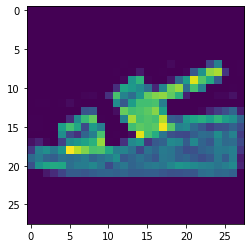

In [43]:
plt.imshow(trainX[9, 0])

# Архитектура модели



In [44]:
# Создаю класс VAE (вариационный автокодировщик)
class VAE(nn.Module):
    def __init__(self):                             # метод создания модели
        super(VAE, self).__init__()                 # наследую свойства родительского класса
        self.fc1 = nn.Linear(inputSize, hidden)     # линейный слой как Dense в Keras (входной размер, выходной размер)
        self.fc21 = nn.Linear(hidden, latent_dim)   # (входной размер, скрытое пространство)
        self.fc22 = nn.Linear(hidden, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden)
        self.fc4 = nn.Linear(hidden, inputSize)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # средн.квадратичное отклонение
        eps = torch.randn_like(std)  # норм распределение
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learningRate)  # оптимизатор

In [45]:
# view отличается от reshape, тем что меняет размер массива только для данной итерации
print (
    f'view: {trainX.view(-1, 28*28).shape}\nи снова: {trainX.size()}'
)

view: torch.Size([100, 784])
и снова: torch.Size([100, 1, 28, 28])


# Функция ошибки 





In [29]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # бинарная кросс энтропия для сравнения картинок
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # расстояние Кульбака-Лейблера
    return BCE + KLD    # складываем для уменьшения ошибки

# Обучение и проверка работы модели



In [46]:
def train(epoch):
    model.train()       # Переводим модель в режим обучения
    train_loss = 0
    losses = []         # Список будем использовать для построения графика
    for batch_idx, (data, _) in enumerate(trainLoader):
        data = data.to(device)                      # загружаем данные на видеокарту
        data = data.view(-1, 28*28)                 # Преобразуем картинки 1,28,28 в вектор 784 
        optimizer.zero_grad()                       # обнуляем градиент
        recon_batch, mu, logvar = model(data)       # делаем предсказание
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() 
        train_loss += loss.item()
        optimizer.step()                            # следующий шаг оптимизации
        if batch_idx % 100 == 0:
            print('"Эпоха обучения": {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainLoader.dataset),
                100. * batch_idx / len(trainLoader),
                loss.item() / len(data)))
        losses.append(train_loss/len(trainLoader.dataset))
    
    print('====> "Эпоха": {} Средний loss: {:.4f}'.format(
          epoch, train_loss / len(trainLoader.dataset)))    

In [47]:
def test(epoch):                      # тест обученой модели
    model.eval()                      # Перевожу модель в режим тестирования, веса замораживаются
    test_loss = 0                     # обнуляю ошибку
    with torch.no_grad():             # Временно отключаю расчет градиента
        for i, (data, _) in enumerate(testLoader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],                               # Объединяю исходные данные и данные предикта которые преобразую 
                              recon_batch.view(batchSize, 1, 28, 28)[:n]])      # в вектор 784 обратно в размер картинки 1х28х28 в переменную
                save_image(comparison.cpu(),
                         'data/reconstruction_' + str(epoch) + '.png', nrow=n)  # Сохраняю полученные результаты в файл

    test_loss /= len(testLoader.dataset)
    print('====> Тестовый loss: {:.4f}'.format(test_loss))

## Обучение модели

In [48]:
for epoch in range(1, numEpochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad(): 
            sample = torch.randn(64, latent_dim).to(device) # Генерирую случайный шум размером latent_dim количеством 64 картинок
            sample = model.decode(sample).cpu()             # Прогоняю шум через декодер
            save_image(sample.view(64, 1, 28, 28),
                       'data/sample_' + str(epoch) + '.png') # Сохраняю полученные результаты в файл

"Эпоха обучения": 1 [0/60000 (0%)]	Loss: 548.975039
"Эпоха обучения": 1 [10000/60000 (17%)]	Loss: 305.437383
"Эпоха обучения": 1 [20000/60000 (33%)]	Loss: 286.361602
"Эпоха обучения": 1 [30000/60000 (50%)]	Loss: 278.149629
"Эпоха обучения": 1 [40000/60000 (67%)]	Loss: 268.965625
"Эпоха обучения": 1 [50000/60000 (83%)]	Loss: 265.128184
====> "Эпоха": 1 Средний loss: 290.3675
====> Тестовый loss: 270.2345
"Эпоха обучения": 2 [0/60000 (0%)]	Loss: 279.817363
"Эпоха обучения": 2 [10000/60000 (17%)]	Loss: 266.601895
"Эпоха обучения": 2 [20000/60000 (33%)]	Loss: 268.426641
"Эпоха обучения": 2 [30000/60000 (50%)]	Loss: 259.873203
"Эпоха обучения": 2 [40000/60000 (67%)]	Loss: 268.301914
"Эпоха обучения": 2 [50000/60000 (83%)]	Loss: 247.558867
====> "Эпоха": 2 Средний loss: 262.2032
====> Тестовый loss: 258.3686
"Эпоха обучения": 3 [0/60000 (0%)]	Loss: 250.181309
"Эпоха обучения": 3 [10000/60000 (17%)]	Loss: 248.417344
"Эпоха обучения": 3 [20000/60000 (33%)]	Loss: 280.508223
"Эпоха обучения": 3 

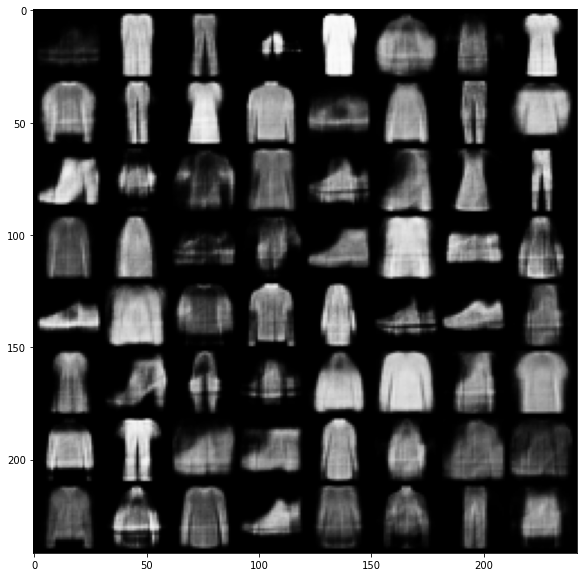

In [49]:
# Примеры из декодера полученные из сгенеренного случайного шума
img = Image.open("/content/data/sample_9.png") 
plt.figure(figsize=(10,10))
plt.imshow(img.convert('RGBA'))
plt.show()

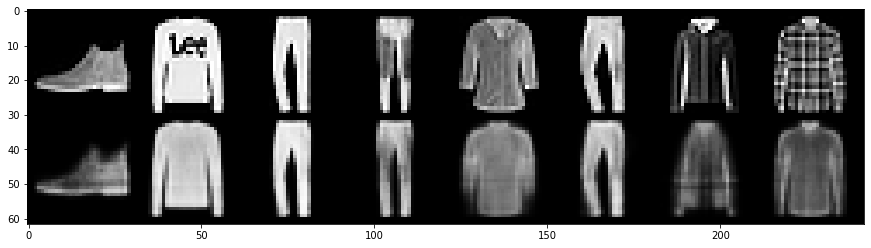

In [50]:
# Примеры из декодера полученные из сгенеренного случайного шума
img = Image.open("/content/data/reconstruction_9.png")
plt.figure(figsize=(15,5))
plt.imshow(img.convert('RGBA'))
plt.show()